In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("HR_comma_sep.csv")
data.head(10)
y, X = dmatrices('left~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+Work_accident+promotion_last_5years+C(sales)+C(salary)', data, return_type='dataframe')
X = np.asmatrix(X)
y = np.ravel(y)

In [3]:
# Normalization
for i in range(1, X.shape[1]):
    xmin = X[:,i].min()
    xmax = X[:,i].max()
    X[:, i] = (X[:, i] - xmin) / (xmax - xmin)

In [4]:
Xtrain,Xvali,ytrain,yvali=train_test_split(X, y, test_size=0.2, random_state=3)

## Overfitting

In [5]:
np.random.seed(1)
alpha = 5 # learning rate
beta = np.random.randn(Xtrain.shape[1]) # 随机初始化参数beta
error_rates_train=[]
error_rates_vali=[]
for T in range(200):
    prob = np.array(1. / (1 + np.exp(-np.matmul(Xtrain, beta)))).ravel()  # 根据当前beta预测离职的概率
    prob_y = list(zip(prob, ytrain))
    loss = -sum([np.log(p) if y == 1 else np.log(1 - p) for p, y in prob_y]) / len(ytrain) # 计算损失函数的值
    error_rate = 0
    for i in range(len(ytrain)):
        if ((prob[i] > 0.5 and ytrain[i] == 0) or (prob[i] <= 0.5 and ytrain[i] == 1)):
            error_rate += 1;
    error_rate /= len(ytrain)
    error_rates_train.append(error_rate)
    
    prob_vali = np.array(1. / (1 + np.exp(-np.matmul(Xvali, beta)))).ravel()  # 根据当前beta预测离职的概率
    prob_y_vali = list(zip(prob_vali, yvali))
    loss_vali = -sum([np.log(p) if y == 1 else np.log(1 - p) for p, y in prob_y_vali]) / len(yvali) # 计算损失函数的值
    error_rate_vali = 0
    for i in range(len(yvali)):
        if ((prob_vali[i] > 0.5 and yvali[i] == 0) or (prob_vali[i] <= 0.5 and yvali[i] == 1)):
            error_rate_vali += 1
    error_rate_vali /= len(yvali)
    error_rates_vali.append(error_rate_vali)
    
    if T % 5 ==0 :
        print('T=' + str(T) + ' loss=' + str(loss) + ' error=' + str(error_rate)+ ' error_vali=' + str(error_rate_vali))
    # 计算损失函数关于beta每个分量的导数
    deriv = np.zeros(Xtrain.shape[1])
    for i in range(len(ytrain)):
        deriv += np.asarray(Xtrain[i,:]).ravel() * (prob[i] - ytrain[i])
    deriv /= len(ytrain)
    # 沿导数相反方向修改beta
    beta -= alpha * deriv

T=0 loss=1.125338568267821 error=0.5052087673972832 error_vali=0.49766666666666665
T=5 loss=0.5487248908520651 error=0.24918743228602383 error_vali=0.24866666666666667
T=10 loss=0.5043810358552849 error=0.23718643220268357 error_vali=0.23833333333333334
T=15 loss=0.48342576427505307 error=0.22626885573797817 error_vali=0.228
T=20 loss=0.46966024320936456 error=0.2187682306858905 error_vali=0.22033333333333333
T=25 loss=0.46010838117706304 error=0.2173514459538295 error_vali=0.22066666666666668
T=30 loss=0.45297590886796885 error=0.2137678139844987 error_vali=0.21666666666666667
T=35 loss=0.44783827517044894 error=0.2173514459538295 error_vali=0.21966666666666668
T=40 loss=0.44403288633042387 error=0.2115176264688724 error_vali=0.213
T=45 loss=0.44119914749615574 error=0.21360113342778564 error_vali=0.216
T=50 loss=0.43903299855922373 error=0.20910075839653305 error_vali=0.21233333333333335
T=55 loss=0.4373425225124252 error=0.20960080006667223 error_vali=0.215
T=60 loss=0.4359976341739

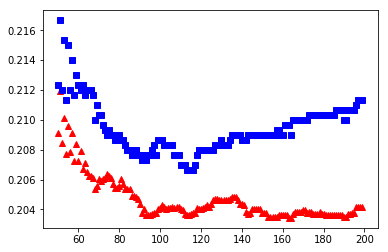

In [6]:
plt.plot(range(50,200), error_rates_train[50:], 'r^', range(50, 200), error_rates_vali[50:], 'bs')
plt.show()

## Gradient checking

In [7]:
np.random.seed(1)
alpha = 1  # learning rate
beta = np.random.randn(X.shape[1]) # 随机初始化参数beta

#dF/dbeta0
prob = np.array(1. / (1 + np.exp(-np.matmul(X, beta)))).ravel()  # 根据当前beta预测离职的概率
prob_y = list(zip(prob, y))
loss = -sum([np.log(p) if y == 1 else np.log(1. - p) for p, y in prob_y]) / len(y) # 计算损失函数的值
deriv = np.zeros(X.shape[1])
for i in range(len(y)):
    deriv += np.asarray(X[i,:]).ravel() * (prob[i] - y[i])
deriv /= len(y)
print('We calculated ' + str(deriv[0]))

delta = 0.0001
beta[0] += delta
prob = np.array(1. / (1 + np.exp(-np.matmul(X, beta)))).ravel()  # 根据当前beta预测离职的概率
prob_y = list(zip(prob, y))
loss2 = -sum([np.log(p) if y == 1 else np.log(1. - p) for p, y in prob_y]) / len(y) # 计算损失函数的值
shouldbe = (loss2 - loss) / delta # (F(b0+delta,b1,...,bn) - F(b0,...bn)) / delta
print('According to definition of gradient, it is ' + str(shouldbe))
if shouldbe == deriv[0]:
    print("Correct!")

We calculated 0.3306924011046167
According to definition of gradient, it is 0.33069903233373665
